# Sharvari Gote

## Introduction to Robotics


# Project 1: Computing all kinematic informations of a real manipulator

In this project (and the next ones), we will build all the necessary various functionalities for realistic robot manipulators. This first project aims to build the core fonctions (basic homogeneous transforms, twists, forward kinematics and Jacobians) that will be a foundation for all subsequent algorithms.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a written answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.


## The robot

We will use a model of the [Kuka iiwa 14 robot](https://www.kuka.com/en-us/products/robotics-systems/industrial-robots/lbr-iiwa). This robot has 7 revolute joints and its kinematics is described in the picture below:

![](https://raw.githubusercontent.com/righetti/ROB6003/143afa17d7eb1af79c3f6ce034973a1774da5d42/Project1/kuka_kinematics.png "Kuka iiwa 14 Kinematic Model")

# Setup

Run the cell below only once when resetting the runtime in Colab - this will not do anything when running on a local Jupyter Notebook.

In [1]:
## check if we are in Google Colab
try:
    import google.colab
    RUNNING_IN_COLAB = True
    print('detected Colab - setting up environment')
    # then we need to install the conda environment
    try:
        import condacolab
        condacolab.check()
    except:
        !pip install -q condacolab
        import condacolab
        condacolab.install()
except:
    RUNNING_IN_COLAB = False

In [2]:
# after installing condalab, the runtime restarts
# -> need to check for colab env once more here
try:
    import google.colab
    RUNNING_IN_COLAB = True
except Exception as e:
    RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    try:
        # Check if packages are installed or not. If not, install them.
        import pinocchio
    except:
        # Install pinocchio, meschat-python 
        !conda install pinocchio meshcat-python
       
    # get the class repo - first check if it exists
    import os, sys
    if not os.path.isdir('/content/ROB6003/Project1'):
      print('cloning LAB repository')
      os.chdir('/content')
      !git clone https://github.com/righetti/ROB6003.git
      print('cloning done')
    else:
      print('lab repos was found, skipping cloning')
    print('done configuring for Colab')
    sys.path.append('/content/ROB6003/Project1/')
    os.chdir('/content/ROB6003/Project1/')
    print('done adding system path and changing directory.')


# Starting the visualization environment

The following code will start a visualization environment (click on the printed address to see the robot)

You need to run this only ONCE. Each time you run this cell you will get a new display environment (so you need to close the previous one!)

This should work out of the box on Google Colab and you local Jupyter Notebook (make sure you have installed the right libraries in your local computer if you do not use Colab).

In [1]:
import numpy as np
import robot_visualizer
import time

import matplotlib.pyplot as plt


robot_visualizer.start_robot_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


C:\Users\SHARVARI\anaconda3\envs\robotics\lib\site-packages\pinocchio\shortcuts.py:45: UserWarning: You passed package dir(s) via argument geometry_model and provided package_dirs.
  geom_model = pin.buildGeomFromUrdf(model, filename, geometry_type, package_dirs)


You should see the Kuka iiwa robot now when going to this page: http://127.0.0.1:7000/static/


# Displaying an arbitrary configuration

You can use the following function to display arbitrary configurations of the robot

In [2]:
# here we display an arbitrary configuration of the robot
q = np.random.sample([7])
print(f'we show the configuration for the angles {q}')
robot_visualizer.display_robot(q
                              )

we show the configuration for the angles [0.30328786 0.94248222 0.21370114 0.79662266 0.7371137  0.74245425
 0.23434519]


## Question 1: basics
In this first set of questions, we aim to write the basic functions to do kinematics
* Write a function ``vec_to_skew(w)`` that transforms a 3D vector (numpy array) into a skew symmetric matrix
* Write a function ``twist_to_skew(V)`` that transforms a 6D twist into a 4x4 matrix (use ``vec_to_skew``)
* Write a function ``exp_twist_bracket(V)`` that returns the exponential of a (bracketed) twist $\mathrm{e}^{[\mathcal{V}]}$ where the input to the function is a 6D twist
* Write a function ``inverseT(T)`` that returns the inverse of a homogeneous transform T
* Write a function ``getAdjoint(T)`` that returns the adjoint of a homogeneous transform T

In [3]:
# Question 1 :

from scipy.linalg import expm 
# Function that transforms a 3D vector (numpy array) into a skew symmetric matrix
# working checked 
def vec_to_skew(w):
    return np.array([[0, -w.item(2), w.item(1)],
                     [w.item(2), 0, -w.item(0)],
                     [-w.item(1), w.item(0), 0]])

# Write a function twist_to_skew(V) that transforms a 6D twist into a 4x4 matrix (use vec_to_skew)
# working checked
def twist_to_skew(V):
    V = np.array(V)
    b = np.zeros((4,4))
    r = np.array([[V.item(0)],[V.item(1)],[V.item(2)]])
    m = vec_to_skew(r)
    b = np.array([[m.item(0),m.item(1), m.item(2),V.item(3)],
                     [m.item(3),m.item(4),m.item(5),V.item(4)],
                     [m.item(6),m.item(7),m.item(8),V.item(5)],
                    [0,0,0,0]])
    return b

#Write a function exp_twist_bracket(V) that returns the exponential of a (bracketed) twist  e[V]  
#where the input to the function is a 6D twist
# function checked 
def exp_twist_bracket(V):

    V = np.array(V)
    sk_v = twist_to_skew(V)
    exp_t = expm(sk_v)
    return exp_t
    
# To get rotation matrix R from homogrnous transform   
# checked properly
def rorR(w):
    w=np.array(w)
    return np.array([[w.item(0),w.item(1),w.item(2)],
                    [w.item(4),w.item(5),w.item(6)],
                    [w.item(8),w.item(9),w.item(10)]])

# To get position matrix P from homogrnous transform
# checked properly
def posP(w):
    w=np.array(w)
    return np.array([[w.item(3)],
                    [w.item(7)],
                    [w.item(11)]])

#Write a function inverseT(T) that returns the inverse of a homogeneous transform T
# checked properly 
def inverseT(T):
    R=rorR(T)
    p=posP(T)
    R_trans = np.linalg.inv(R)
    R_trans_p = -np.dot(R_trans,p)
    T_inverse = np.array([[R_trans.item(0),R_trans.item(1), R_trans.item(2),R_trans_p.item(0)],
                     [R_trans.item(3),R_trans.item(4),R_trans.item(5),R_trans_p.item(1)],
                     [R_trans.item(6),R_trans.item(7),R_trans.item(8),R_trans_p.item(2)],
                    [0,0,0,1]])
    return T_inverse

# Gives adjoint transformation
def getAdjoint(T):
    T = np.array(T)
    R=rorR(T)
    p=posP(T)
    pt=vec_to_skew(p)@R
    return np.array([[R.item(0),R.item(1),R.item(2),0,0,0],
                     [R.item(3),R.item(4),R.item(5),0,0,0],
                     [R.item(6),R.item(7),R.item(8),0,0,0],
                     [pt.item(0),pt.item(1),pt.item(2),R.item(0),R.item(1),R.item(2)],
                     [pt.item(3),pt.item(4),pt.item(5),R.item(3),R.item(4),R.item(5)],
                     [pt.item(6),pt.item(7),pt.item(8),R.item(6),R.item(7),R.item(8)]])

## Question 2: forward kinematics
* Write a function ``forward_kinematics(theta)`` that gets as an input an array of joint angles and computes the pose of the end-effector.

In order to test this function, you are given the following forward kinematics results (up to $10^{-4}$ precision),

$T_{SH}(0,\ 0,\ 0,\ 0,\ 0,\ 0,\ 0) = \begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 1.301 \end{bmatrix}$,

$T_{SH}(0.2,\ -0.2,\ 0.5,\ -0.4,\ 1.2,\ -0.8,\ 0.4) = \begin{bmatrix}
-0.4951 & -0.814 &  0.3037 & -0.0003 \\
0.6286 & -0.5769 & -0.5215 &  0.0056\\
0.5997 & -0.0673 &  0.7974 &  1.2563\\
0.  &    0.  &    0.  &    1.\end{bmatrix}$

$T_{SH}(-1.2,\ 0.7,\ 2.8,\ 0.7,\ 1.2,\ 0.2,\ 0.3) = \begin{bmatrix}
-0.9669 & -0.254 &  -0.0234 &  0.1535\\
0.0976 & -0.2835 & -0.954 &  -0.7557\\
0.2357 & -0.9247 &  0.2989 &  0.795\\
 0.  &    0.  &    0.  &    1.\end{bmatrix}$

In [ ]:
# This function takes array of joint angles(theta) and then computes the pose of the end-effector
# Here homogenous tranform at zero position is denoted by M 
# s1,s2,s3,s4,s5,s6,s7= Screw matrix of each joint 
# Step1: The function twist_to_skew has been implemented to find Skew matrix = [s]
# Step2: [S]*theta
# Step 3: exponential of the [S]*theta using expm 
# Step 4: forward kinematics formula has been used
def forward_kinematics(theta):
    theta =np.array(theta)
    # Homogenous transform when all thetas are zero
    M = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1.301],[0,0,0,1]])
    # e([s1]*theta1)
    s1 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk1 = twist_to_skew(s1)
    ex_S_twi_sk1 = expm(S_twi_sk1*theta.item(0))
    # e([s2]*theta2)
    s2 = np.array([[0.],[1.],[0.],[-0.360],[0.],[0.]])
    S_twi_sk2 = twist_to_skew(s2)
    ex_S_twi_sk2 = expm(S_twi_sk2*theta.item(1))
    # (e[s3]*theta3)
    s3 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk3 = twist_to_skew(s3)
    ex_S_twi_sk3 = expm(S_twi_sk3*theta.item(2))
    # e([s4]*theta4)
    s4 = np.array([[0.],[-1.],[0.],[0.78],[0.],[0.]])
    S_twi_sk4 = twist_to_skew(s4)
    ex_S_twi_sk4 = expm(S_twi_sk4*theta.item(3))
    # e[s5]*theta5
    s5 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk5 = twist_to_skew(s5)
    ex_S_twi_sk5 = expm(S_twi_sk5*theta.item(4))
    # e[s6]*theta6
    s6 = np.array([[0.],[1.],[0.],[-1.18],[0.],[0.]])
    S_twi_sk6 = twist_to_skew(s6)
    ex_S_twi_sk6 = expm(S_twi_sk6*theta.item(5))
    # e[s7]*theta7
    s7 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk7 = twist_to_skew(s7)
    ex_S_twi_sk7 = expm(S_twi_sk7*theta.item(6))
    t = ex_S_twi_sk1@ex_S_twi_sk2@ex_S_twi_sk3@ex_S_twi_sk4@ex_S_twi_sk5@ex_S_twi_sk6@ex_S_twi_sk7@M

    return t
    

## Question 3: jacobians
* Write a function ``get_space_jacobian(theta)`` that computes the space jacobian given an array of joint angles

In order to test this function, you are given the following space Jacobian results (up to $10^{-3}$ precision),
$J^S(0,\ 0,\ 0,\ 0,\ 0,\ 0,\ 0) = \begin{bmatrix}
   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000\\
   0.000 &   1.000 &   0.000 & -1.000 &   0.000 &   1.000 &   0.000\\
   1.000 &   0.000 &   1.000 &   0.000 &   1.000 &   0.000 &   1.000\\
   0.000 & -0.360 &   0.000 &   0.780 &   0.000 & -1.180 &   0.000\\
   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000\\
   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000
\end{bmatrix}
$,

$J^S(0.2,\ -0.2,\ 0.5,\ -0.4,\ 1.2,\ -0.8,\ 0.4) = \begin{bmatrix}
   0.000 & -0.199 & -0.195 &   0.635 &   0.112 & -0.943 &   0.304\\
   0.000 &   0.980 & -0.039 & -0.767 &   0.213 & -0.287 & -0.522\\
   1.000 &   0.000 &   0.980 &   0.095 &   0.971 &   0.172 &   0.797\\
   0.000 & -0.353 &   0.014 &   0.590 & -0.181 &   0.344 &   0.660\\
   0.000 & -0.072 & -0.070 &   0.498 &   0.166 & -1.087 &   0.382\\
   0.000 &   0.000 &   0.000 &   0.073 & -0.016 &   0.075 & -0.002
\end{bmatrix}$

$J^S(-1.2,\ 0.7,\ 2.8,\ 0.7,\ 1.2,\ 0.2,\ 0.3) = \begin{bmatrix}
   0.000 &   0.932 &   0.233 &   0.971 &   0.146 & -0.528 & -0.023\\
   0.000 &   0.362 & -0.600 &   0.103 & -0.970 & -0.242 & -0.954\\
   1.000 &   0.000 &   0.765 & -0.216 &   0.194 & -0.814 &   0.299\\
   0.000 & -0.130 &   0.216 & -0.015 &   0.612 &   0.705 &   0.533\\
   0.000 &   0.336 &   0.084 &   0.683 &   0.080 & -0.274 & -0.065\\
   0.000 &   0.000 &   0.000 &   0.255 & -0.058 & -0.376 & -0.164
\end{bmatrix}$

In [5]:
# This function get_space_jacobian(theta) that computes the space jacobian given an array of joint angles
# Step 1: From the previous question we use all the calculated M and screw matrices and it's calculates exponentials 
# Step 2: We take adjoint using the function getAdjoint 
# Step 3: The adjoint is then multplied with screw matrix of the repective joint to obtain  
#Space Jocabian(Js_1 for joint 1 and then so on..)
# Step 4: We use np.hstack function for combing all individual space jacobians calculated  
def get_space_jacobian(theta):
    theta =np.array(theta)
    #e[s1]*theta1
    s1 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk1 = twist_to_skew(s1)
    ex_S_twi_sk1 = expm(S_twi_sk1*theta.item(0))
    # space jocabian for 1st joint
    Js_1 = s1
    # e[s2]*theta2
    s2 = np.array([[0.],[1.],[0.],[-0.360],[0.],[0.]])
    S_twi_sk2 = twist_to_skew(s2)
    ex_S_twi_sk2 = expm(S_twi_sk2*theta.item(1))
    
    # space jocabian for 2nd joint
    Js_2 = getAdjoint(ex_S_twi_sk1)@s2
    
    # e[s3]*theta3
    s3 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk3 = twist_to_skew(s3)
    ex_S_twi_sk3 = expm(S_twi_sk3*theta.item(2))
    
    e_12 = ex_S_twi_sk1@ex_S_twi_sk2
    
    #  space jocabian for 3rd joint
    Js_3 = getAdjoint(e_12)@s3
    
    # e[s4]*theta4
    s4 = np.array([[0.],[-1.],[0.],[0.78],[0.],[0.]])
    S_twi_sk4 = twist_to_skew(s4)
    ex_S_twi_sk4 = expm(S_twi_sk4*theta.item(3))
    
    e_23 = e_12@ex_S_twi_sk3
    
    #  space jocabian for 4th joint
    Js_4 = getAdjoint(e_23)@s4
    
    # e[s5]*theta5
    s5 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk5 = twist_to_skew(s5)
    ex_S_twi_sk5 = expm(S_twi_sk5*theta.item(4))
    
    e_34 = e_23@ex_S_twi_sk4
    #  space jocabian for 5th joint
    Js_5 = getAdjoint(e_34)@s5
    
    # e[s6]*theta6
    s6 = np.array([[0.],[1.],[0.],[-1.18],[0.],[0.]])
    S_twi_sk6 = twist_to_skew(s6)
    ex_S_twi_sk6 = expm(S_twi_sk6*theta.item(5))
    
    e_45 = e_34@ex_S_twi_sk5
    
    #  space jocabian for 6th joint
    Js_6 = getAdjoint(e_45)@s6
    
    s7 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk7 = twist_to_skew(s7)
    ex_S_twi_sk7 = expm(S_twi_sk7*theta.item(6))
    
    e_56 = e_45@ex_S_twi_sk6
    
    # space jocabian for 7th joint
    Js_7 = getAdjoint(e_56)@s7
    
    J = np.hstack([Js_1,Js_2,Js_3,Js_4,Js_5,Js_6,Js_7])
    return J             
    

### Hint: Q2 and Q3
Depending on which method you use to compute the quantities of Q2 and Q3, you will need to define a series of fixed homogeneous transforms, screws, etc. You may want to store these values in various variables that you can reuse (i.e. define the fixed kinematic parameters once and for all).

You may also want to store some intermediate results to later compute the Jacobians.

Feel free to design the data structure that you prefer and to also pass additional parameters or return multiple variables with these functions if it simplifies your design. You can also put these functions in a class if you wish. Any solution is ok, as long as you can compute the requested quantities.

Make sure to explain your design in the report.

## Question 4: displaying hand trajectories 
You are given a file ``joint_trajectory.npy`` which contains a sequence of 100 joint configurations (cf. below) corresponding to a motion of the robot over time.
* Compute the position of the hand (i.e. the origin of the frame H) in the spatial frame for all 100 joint configuration
* Plot x-y position of the hand for all the configurations (i.e. a 2D plot with x as the abscissa and y as the ordinate of the graph). What does the hand draw?
* Do the same analysis and plots for the x-z and y-z pairs.

### Hint
You may use (matplotlib)[https://matplotlib.org/] to draw plots

In [6]:
# we open the file and put all the data in the variable joint_trajectory 
# this gives us a 7 x 200 array (each column in one set of joint configurations)
with open('joint_trajectory.npy', 'rb') as f:
    joint_trajectory = np.load(f)
# we display the trajectory
n_samples = joint_trajectory.shape[1]
for i in range(n_samples):
    robot_visualizer.display_robot(joint_trajectory[:,i])
    time.sleep(0.05) # we wait between two displays so we can see each configuration

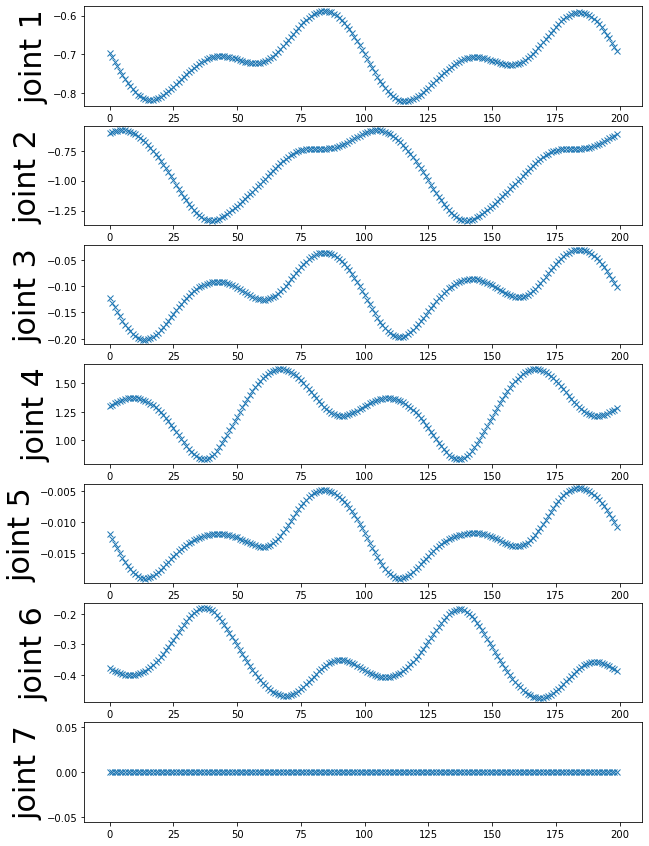

In [7]:
# now we plot the joint trajectories for each joint (each cross correspond to one data point)
plt.figure(figsize=[10,15])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(joint_trajectory[i,:], 'x', linewidth=4)
    plt.ylabel(f'joint {i+1}', fontsize=30)

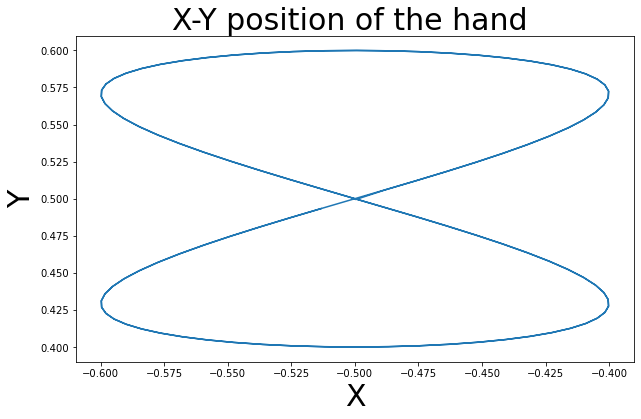

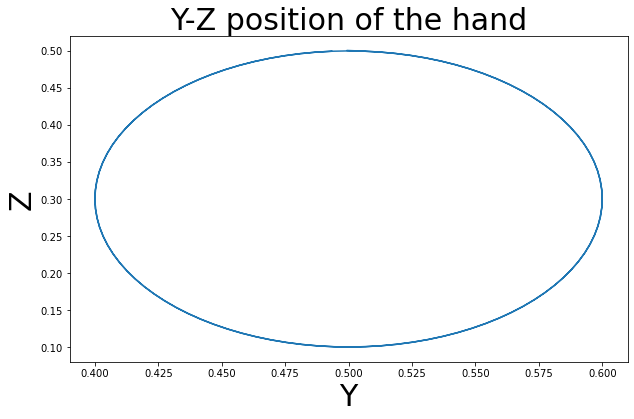

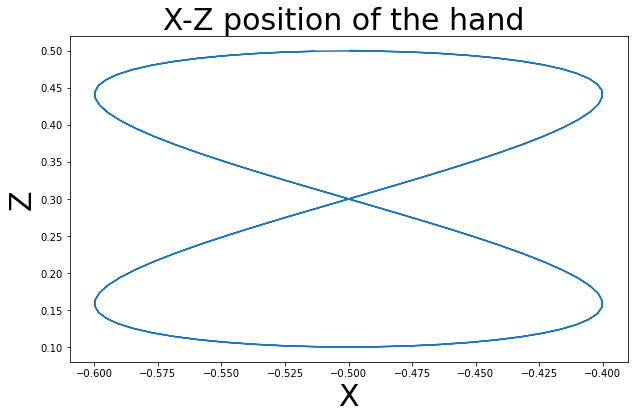

In [8]:
# Question 4:

# Task: is to compute the position of the hand in the spatial frame for all 100 joint configuration

#Step 1: We open the file and store all the data in the variable joint_trajectory 
#Step 2: We compute the pose of the end-effector in spatial frame for each of the given 100 configurations(T_trans) using 
#forward_kinematic function 
#Step 3: From the 4by4 matrix we obtain get position  of the hand in the spatial frame for all 100 joint configuration
#Step 4: The plots have been constructed below accordingly
pos_x, pos_y, pos_z = [], [], []
T_trans = np.zeros([200,4,4])
for i in range(joint_trajectory.shape[1]):
    T_trans[i,:] = forward_kinematics(joint_trajectory[:,i])
    x1, y1, z1 = T_trans[i][:3, -1]
    pos_x.append(x1)
    pos_y.append(y1)
    pos_z.append(z1)
# This the plot of X-Y position of the hand 
# The hand draws an eight in X-Y plane
plt.figure(figsize=[10, 6])
plt.plot(pos_x, pos_y)
plt.xlabel('X', fontsize=30)
plt.ylabel('Y', fontsize=30)
plt.title('X-Y position of the hand ',fontsize=30)
# This the plot of Y-Z position of the hand 
# The hand draws a circle in Y-Z plane
plt.figure(figsize=[10, 6])
plt.plot(pos_y, pos_z)
plt.xlabel('Y', fontsize=30)
plt.ylabel('Z', fontsize=30)
plt.title('Y-Z position of the hand',fontsize=30)
# This the plot of X-Z position of the hand 
# The hand draws an eight in X-Z plane
plt.figure(figsize=[10, 6])
plt.plot(pos_x, pos_z)
plt.xlabel('X', fontsize=30)
plt.ylabel('Z', fontsize=30)
plt.title('X-Z position of the hand ',fontsize=30)
plt.show()

## Question 5: computing velocities
The file ``joint_velocities.npy`` contains the velocities of each joint corresponding to the sequence joint configurations seen in the previous question. 
* Use the Jacobian to compute the linear velocity of the endeffector in: 1) the spatial frame. 2) the end-effector frame and 3) in a frame with same origin as the end-effector frame but oriented like the spatial frame
* Plot these velocities in each frame (one plot per dimension x,y,z)
* Compare these plots and relate them to the plot of the positions (Question 4), is there a frame that seems most intuitive to you? Why?

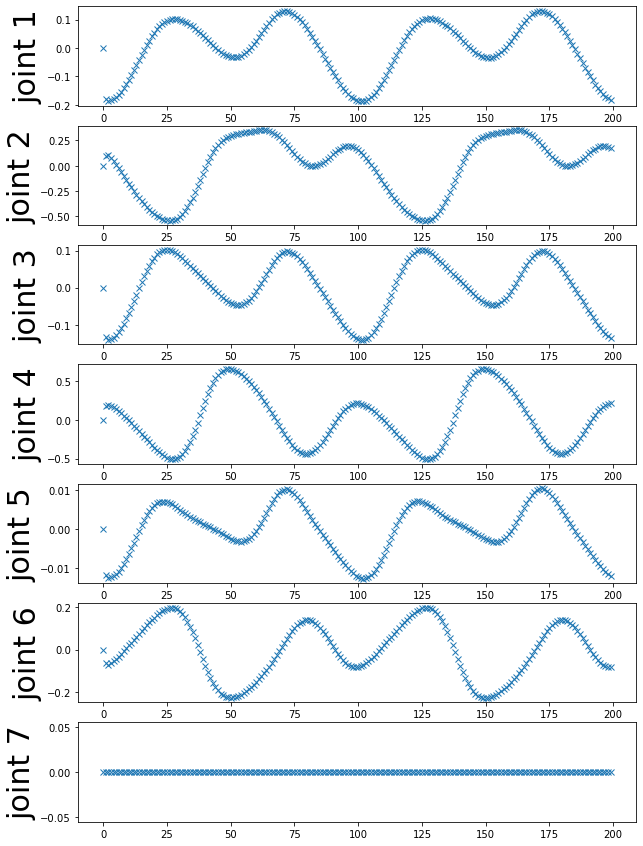

In [9]:
# we open the file and put all the data in the variable joint_trajectory 
# this gives us a 7 x 200 array (each column in one set of joint configurations)
with open('joint_velocity.npy', 'rb') as f:
    joint_velocities = np.load(f)
# now we plot the joint velocities for each joint (each cross correspond to one data point)
plt.figure(figsize=[10,15])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(joint_velocities[i,:], 'x', linewidth=4)
    plt.ylabel(f'joint {i+1}', fontsize=30)

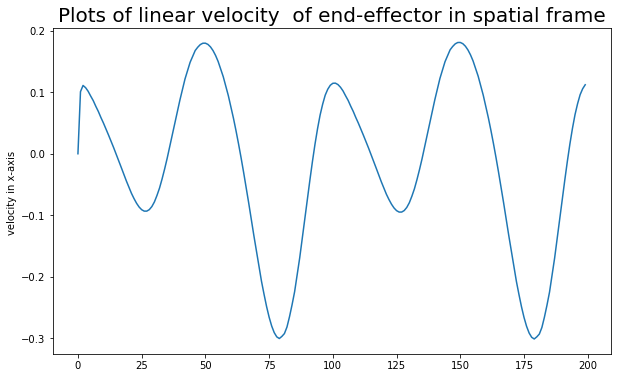

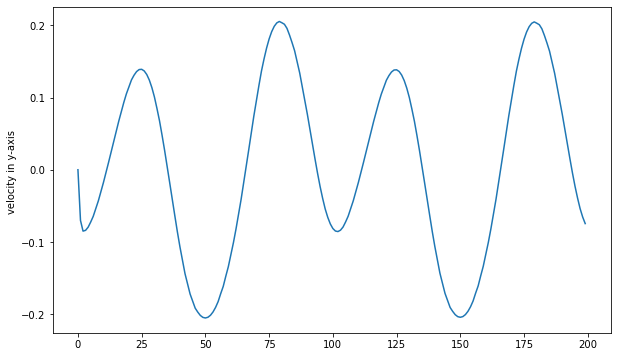

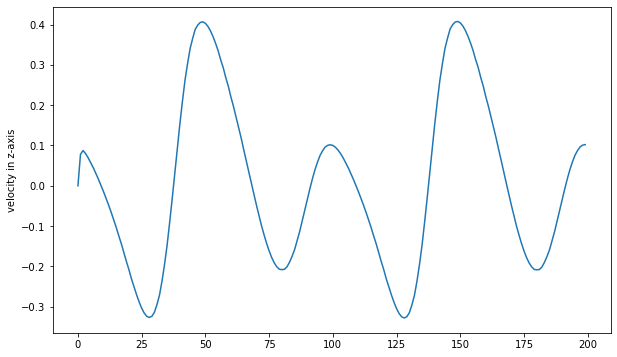

In [10]:
# Code: for 5 
#Part 1
# 5 Part 1 
#Task:Use the Jacobian to compute the linear velocity of the endeffector in the spatial frame.
# Step 1: We get space jacobian for each  of the configuration using get_space_jacobian() function written previously.
#Step 2: The space jacobian obtained is then multiplied with joint velocities which gives us spatial twist.
#Step 3: From Spatial twist we obtain linear velocity of the endeffector in the spatial frame (linvel_s)
V_s = np.zeros([6, 200])
linvel_s = np.zeros([200, 3])
for i in range(joint_velocities.shape[1]):
    V_s[:,i] = get_space_jacobian(joint_trajectory[:,i])@joint_velocities[:,i]
    linvel_s[i,:] = V_s[3:,i]
# PLOT 1: Plotting linear velocity in x-axis of end-effector in spatial frame 
plt.figure(figsize=[10, 6])
plt.title('Plots of linear velocity  of end-effector in spatial frame',fontsize=20)
plt.plot(linvel_s[:,0])
plt.ylabel('velocity in x-axis ', fontsize=10)
# PLOT 2: Plotting linear velocity in y-axis of end-effector in spatial frame 
plt.figure(figsize=[10, 6])
plt.plot(linvel_s[:,1])
plt.ylabel('velocity in y-axis ', fontsize=10)
# PLOT 3: Plotting linear velocity in z-axis of end-effector in spatial frame 
plt.figure(figsize=[10, 6])
plt.plot(linvel_s[:,2])
plt.ylabel('velocity in z-axis', fontsize=10)
plt.show()

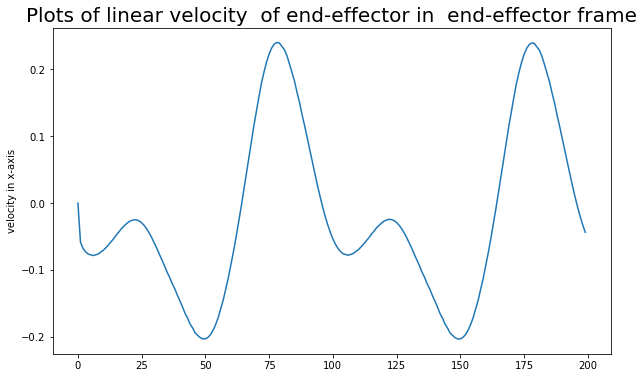

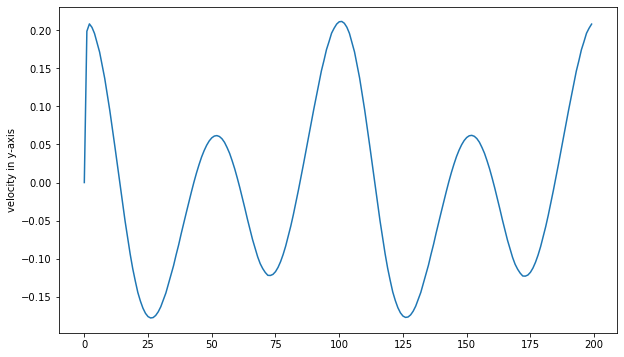

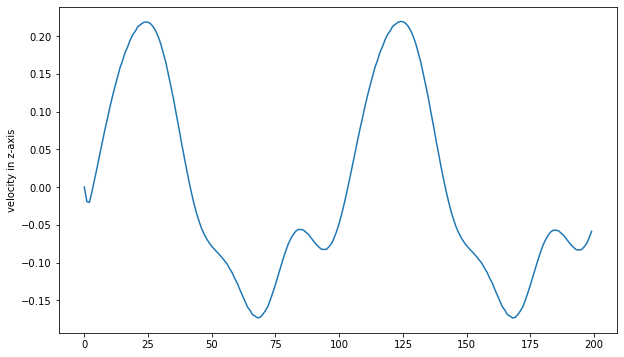

In [11]:
# Code: for 5 
#Part 2
# 5 Part 2
#Task :Use the Jacobian to compute the linear velocity of the end-effector in the  end-effector frame.
# Step 1: From question 5 part 1 we get spatial twist for each configuration.
# Step 2: We compute Homogenous transformation matrix for each of the configuration (T_trans) (answer of question 4)
# Step 3: We take inverse of the Homogenous transformation matrix for each of the configuration using the inverseT() function 
# Step 4: Then adjoint of the inverse of the Homogenous transformation matrix for each of the configuration is computed using getAdjoint()
# Step 5: Body twist is obtained by multiplying this adjoint by spatial twist.
# Step 6: From Body twist we obtain linear velocity of the end-effector in the  end-effector frame (linvel_b)
linvel_b = np.zeros([200, 3])

for i in range(joint_trajectory.shape[1]):
    V_b = getAdjoint(inverseT(T_trans[i]))@V_s[:,i]
    linvel_b[i,:] = V_b[3:]
# PLOT 1: Plotting linear velocity in x-axis of end-effector in  end-effector frame 
plt.figure(figsize=[10, 6])
plt.title('Plots of linear velocity  of end-effector in  end-effector frame',fontsize=20)
plt.plot(linvel_b[:,0])
plt.ylabel('velocity in x-axis', fontsize=10)
# PLOT 2: Plotting linear velocity in y-axis of end-effector in  end-effector frame 
plt.figure(figsize=[10, 6])
plt.plot(linvel_b[:,1])
plt.ylabel('velocity in y-axis', fontsize=10)
# PLOT 3: Plotting linear velocity in z-axis of end-effector in  end-effector frame 
plt.figure(figsize=[10, 6])
plt.plot(linvel_b[:,2])
plt.ylabel('velocity in z-axis', fontsize=10)
plt.show()

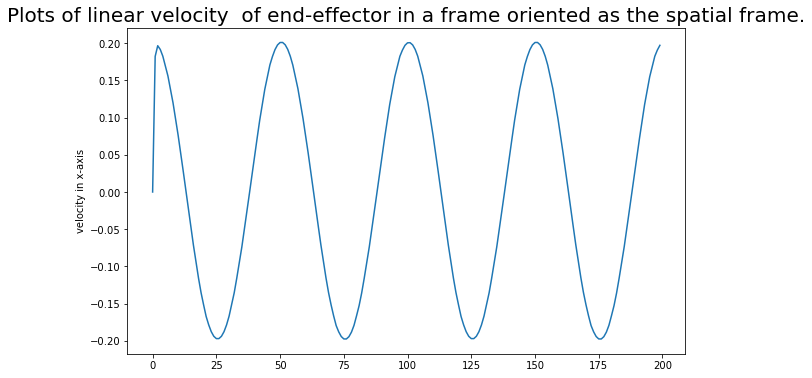

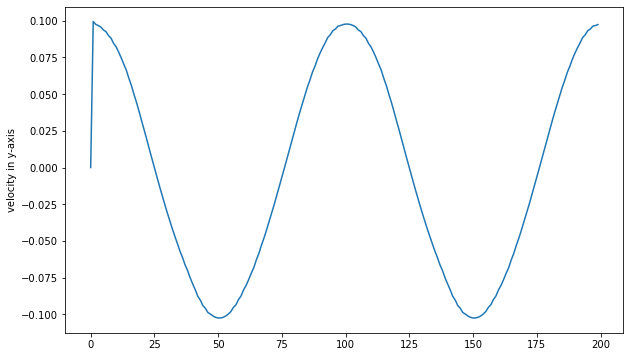

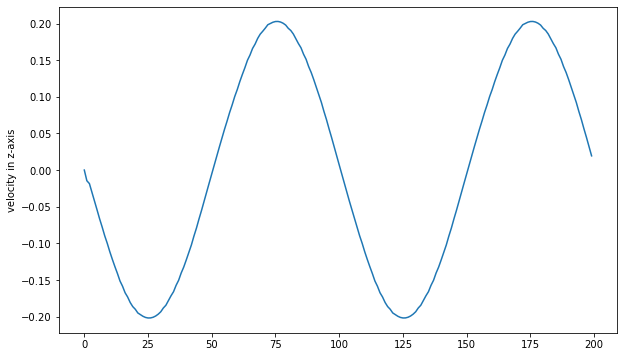

In [12]:
# Code: for 5 
#Part 3
# 5 Part 3:
#Task :Use the Jacobian to compute the linear velocity of the endeffector in a frame oriented as the spatial frame.
#Step 1:The frame has same orientation as spatial frame so the rotation matrix of each of the Homogenous transformation..
# .. is replaced by I(3*3 identity matrix)- (T_transe).
#Step 2: The adjoint of inverse of T_transe is taken.
#Step 3: Then this multiplied by spatial twist to obtain body twist(V_be) in a frame oriented as the spatial frame.
#Step 4: From the body twist (V_be) we obtain linear velocity of the endeffector in a frame oriented as the spatial frame.
linvel_be = np.zeros([200, 3])
T_transe = np.copy(T_trans)

for i in range(joint_trajectory.shape[1]):
    T_transe[i][:3,:3] = np.eye(3)
    V_be = getAdjoint(inverseT(T_transe[i]))@get_space_jacobian(joint_trajectory[:,i])@joint_velocities[:,i]
    linvel_be[i] = V_be[3:]
# PLOT 1: Plotting linear velocity in x-axis of end-effector in a frame oriented as the spatial frame.
plt.figure(figsize=[10, 6])
plt.title('Plots of linear velocity  of end-effector in a frame oriented as the spatial frame.',fontsize=20)
plt.plot(linvel_be[:,0])
plt.ylabel('velocity in x-axis', fontsize=10)
# PLOT 2: Plotting linear velocity in y-axis of end-effector in a frame oriented as the spatial frame.
plt.figure(figsize=[10, 6])
plt.plot(linvel_be[:,1])
plt.ylabel('velocity in y-axis', fontsize=10)
# PLOT 3: Plotting linear velocity in z-axis of end-effector in a frame oriented as the spatial frame.
plt.figure(figsize=[10, 6])
plt.plot(linvel_be[:,2])
plt.ylabel('velocity in z-axis', fontsize=10)
plt.show()

##### End of Project